In [17]:
%%file oscillator_solution.py
#/usr/bin/env python
# -*- coding: utf-8 -*-

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs

import pyNN.hardware.spikey as pynn

pynn.setup()

CHAIN_LENGTH = 14 # number of chain links
POPSIZE_EXC = 8   # size of excitatory populations
POPSIZE_INH = 5   # size of inhibitory populations

WEIGHT_STIM = 8 * pynn.minExcWeight()     # weight of stimulus
WEIGHT_EXC_EXC =  5 * pynn.minExcWeight() # weight of exc → exc connections
WEIGHT_EXC_INH =  5 * pynn.minExcWeight() # weight of exc → inh connections
WEIGHT_INH_EXC = 10 * pynn.minInhWeight() # weight of inh → exc connections

# set up stimulus
spike_train = np.array([100.0])
stimulus = pynn.Population(4, pynn.SpikeSourceArray, {'spike_times': spike_train})

# list containing all populations
chain = []

params = {
    "g_leak": 15.0
}

for i in xrange(CHAIN_LENGTH):
    pop_exc = pynn.Population(POPSIZE_EXC, pynn.IF_facets_hardware1, params)
    pop_inh = pynn.Population(POPSIZE_INH, pynn.IF_facets_hardware1, params)
    
    pop_exc.record()
    pop_inh.record()
    
    chain.append((pop_exc, pop_inh))

# record membrane voltage of first neuron of first excitatory population
pynn.record_v(chain[0][0][0], "")
    
# connect stimulus
proj = pynn.Projection(stimulus, chain[0][0], pynn.AllToAllConnector(weights=WEIGHT_STIM))

# connect chain
for i in xrange(CHAIN_LENGTH):
    # connect exc → exc
    pynn.Projection(
        chain[i][0],
        chain[(i + 1) % CHAIN_LENGTH][0],
        pynn.AllToAllConnector(weights=WEIGHT_EXC_EXC),
        target="excitatory"
        )
    
    # connect exc → inh
    pynn.Projection(
        chain[i][0],
        chain[(i + 1) % CHAIN_LENGTH][1],
        pynn.AllToAllConnector(weights=WEIGHT_EXC_INH),
        target="excitatory"
        )

    # connect inh → exc
    pynn.Projection(
        chain[i][1],
        chain[i][0],
        pynn.AllToAllConnector(weights=WEIGHT_INH_EXC),
        target="inhibitory"
        )

# execute experiment
pynn.run(1000.0)

# get membrane trace…
time = pynn.timeMembraneOutput
trace = pynn.membraneOutput

# … and spikes
spikes_exc = np.zeros((0, 2))
spikes_inh = np.zeros((0, 2))

for i, (pop_exc, pop_inh) in enumerate(chain):
    spikes_exc = np.vstack([spikes_exc, pop_exc.getSpikes()])
    spikes_inh = np.vstack([spikes_inh, pop_inh.getSpikes()])

# Create latch

latch = pynn.Population(5, pynn.IF_facets_hardware1)

latch.record()

proj_latch_exc = pynn.Projection(
    chain[0][0],
    latch,
    pynn.AllToAllConnector(weights=15*pynn.minExcWeight()),
    target="excitatory"
)

proj_latch_inh = pynn.Projection(
    chain[CHAIN_LENGTH//2][1],
    latch,
    pynn.AllToAllConnector(weights=15*pynn.minInhWeight()),
    target="inhibitory"
)

proj_latch_recurrent = pynn.Projection(
    latch,
    latch,
    pynn.FixedProbabilityConnector(0.5, weights=7*pynn.minExcWeight()),
    target="excitatory"
)

# record membrane voltage of a latch neuron
pynn.record_v(latch[3], "")

pynn.run(1000.0)

time = pynn.timeMembraneOutput
trace = pynn.membraneOutput

spikes_exc = np.zeros((0, 2))
spikes_inh = np.zeros((0, 2))
for i, (pop_exc, pop_inh) in enumerate(chain):
    se = pop_exc.getSpikes()
    spikes_exc = np.vstack([spikes_exc, se])
    
    si = pop_inh.getSpikes()
    spikes_inh = np.vstack([spikes_inh, si])

spikes_latch = latch.getSpikes()

pynn.end()

fig = plt.figure(figsize=(12, 6))
grid = gs.GridSpec(2, 1, height_ratios=(5, 1))

# plot spikes
ax_spikes = fig.add_subplot(grid[0,0])
ax_trace = fig.add_subplot(grid[1,0])

ax_spikes.set_ylabel(r"neuron index")
ax_spikes.axes.get_xaxis().set_visible(False)

for nrn in np.unique(spikes_exc[:,0]):
    mask = (spikes_exc[:,0] == nrn)
    se = spikes_exc[mask,1]
    
    ax_spikes.plot(se, np.ones_like(se) * nrn, "|", ms=5, c="#AF5A50")

for nrn in np.unique(spikes_inh[:,0]):
    mask = (spikes_inh[:,0] == nrn)
    si = spikes_inh[mask,1]
    
    ax_spikes.plot(si, np.ones_like(si) * nrn, "|", ms=5, c="#005B82")

for nrn in np.unique(spikes_latch[:,0]):
    mask = (spikes_latch[:,0] == nrn)
    sl = spikes_latch[mask,1]
    
    ax_spikes.plot(sl, np.ones_like(sl) * nrn, "|", ms=5, c="#7D966E")

# plot membrane trace
ax_trace.plot(time, trace)
ax_trace.set_xlabel(r"time [\si{\milli\second}]")
ax_trace.set_ylabel(r"$V_\text{m}$ [\si{\milli\volt}]")

fig.savefig("oscillator_solution.png")

Overwriting oscillator_solution.py


In [18]:
! srun --gres=station548 python oscillator_solution.py

/wang/environment/software/jessie/spikey/github_20170208/lib/python2.7/site-packages/pyNN/random.py:25: UserWarning: GSL random number generators not available
  warnings.warn("GSL random number generators not available")
INFO  HAL.Ctr Retrieved station548 from environment variable MY_STAGE1_STATION
INFO  HAL.Ctr Config successfully loaded from file /wang/environment/software/jessie/spikey/github_20170208/spikeyhal/config/station548.cfg
INFO  HAL.Ctr Opening FPGA board with serial B291670
INFO  PyN.wks Using station station548
INFO  HAL.Spi Found Spikey 5.
INFO  PyN.cfg Calibrations NeuronMems Icb bioDynrange NOT loaded!
INFO  HAL.PyS Hardware config written (enable loglevel 3 to list parameter names)
WARN  PyN.cfg Membrane time constant is outside calibrated range for neurons [54, 68, 71, 109, 125, 129, 132, 133, 136, 140, 165, 170, 177, 178, 180]
WARN  PyN.cfg Bad calibration of membrane time constant for neurons [23, 27, 29, 45, 57, 59, 60, 63, 89]; blacklist if necessary
WARN  HAL.

In [19]:
from IPython.display import Image

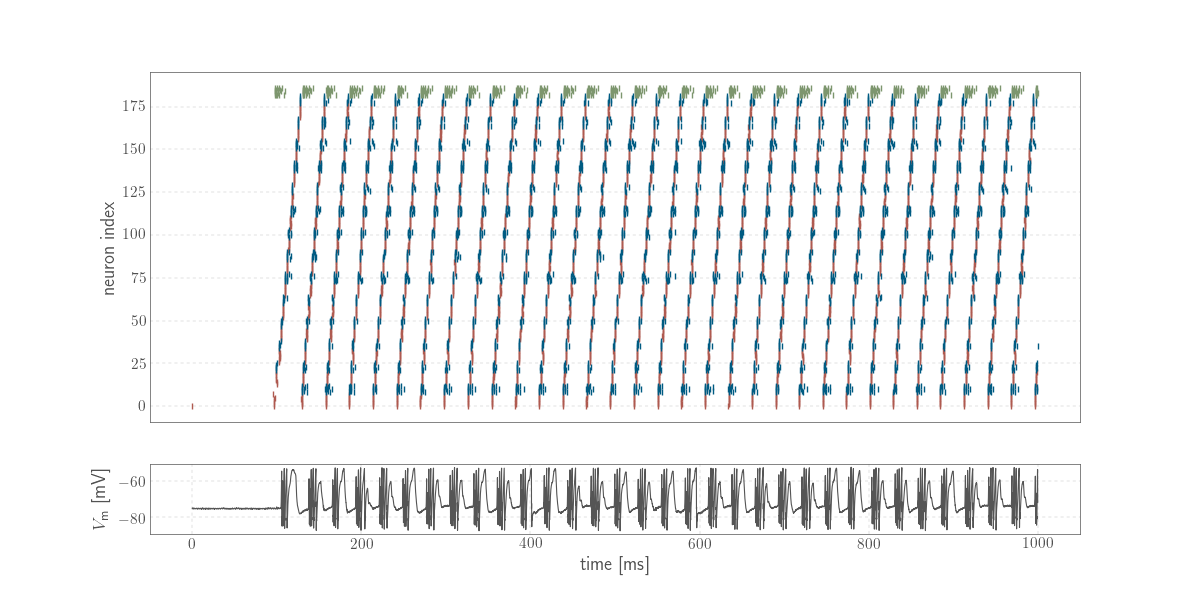

In [20]:
Image(filename="oscillator_solution.png")